##### Gaussian Process for Western Wheat

In [5]:
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from theano import tensor as tt
import scipy.stats as st
import seaborn as sns
import scipy

In [258]:
#datapath = '/home/brian/WesternWheat/Data/Processed/stripped_mini_maxseason_labeled_df_23.csv'
datapath = '/home/brian/WesternWheat/Data/Processed/stripped_max_labeled_df_23.csv'
#datapath = '/home/brian/WesternWheat/Data/Processed/maxdf_23.csv'

df = pd.read_csv(datapath)
Num_farms = pd.unique(df.pixel).size
print ('there are {} unique farms in loaded df'.format(Num_farms))
df_unique =  df.set_index('pixel')
df_unique = df_unique[~df_unique.index.duplicated(keep='first')] # only keep unique index value

farm_idx = df.pixel.values.astype(int)
N_farms = pd.unique(df.pixel).size
#====================================
# reindexing pixels from 0-Nfarms
#====================================
zero_farm_idx = np.zeros_like(farm_idx)

for i,farm in enumerate((np.unique(farm_idx))):
        for j in np.where(farm_idx == farm): 
            zero_farm_idx[j] = int(i)   
            
##########################################################
# This keeps order only becuase df is sorted by farm_idx
#########################################################
df['farm'] = zero_farm_idx

there are 874 unique farms in loaded df


In [247]:
###########################
# ==== distance matrix ====
###########################

from scipy.spatial import distance_matrix
from geopy.distance import geodesic


def distancematrix(df, sparse=True, dlim=100):
    unique_farms = pd.unique(df.pixel)
    distance = np.zeros((unique_farms.size,unique_farms.size))
    df_unique = df.set_index('pixel')
    df_unique = df_unique[~df_unique.index.duplicated(keep='first')] # only keep unique index values

    for i in range(unique_farms.size):
        lat_lon_i = df_unique.Latitude.iloc[i],df_unique.Longitude.iloc[i]
        for j in range(unique_farms.size):
            lat_lon_j = df_unique.Latitude.iloc[j],df_unique.Longitude.iloc[j]
            distance[i,j] = geodesic(lat_lon_i, lat_lon_j).miles
            if sparse == True and distance[i,j]>dlim:
                distance[i,j] = np.NaN
    return distance


distance = distancematrix(df, True, dlim=100)
Dmatsq = np.power(distance, 2)

KeyboardInterrupt: 

In [243]:
rhos = np.array([1e-4,8e-5,5e-5,3e-5,1e-5])
etas = np.array([.5,1])
etas = 1 
t_sparse_allfarms = {} #empty trace dict to store traces in
# ==== Model I want to reparm =====
counter = 0
for j, e in enumerate(etas):
    for i,r in enumerate(rhos):
        counter +=1
        with pm.Model() as GP:

            # ====== covariance matrix ========
            #etasq = pm.HalfCauchy('etasq', 1) # sets maximum covariance ij
            etasq = e # pm.Uniform('etasq', 0,1) 
            #rhosq = pm.HalfCauchy('rhosq', 1.5e-6) # determines rate of covariance decline between farms
            rhosq = r # pm.Uniform('rhosq',lower=0,upper=1e-5)
            sigmay = 1e-2
            # will have very small posterior because distances are so large in Dmatsq
            Kij = etasq*(np.exp(-rhosq*Dmatsq)+np.diag([sigmay]*Num_farms))


            # ========== gaussian process ===========
            w = pm.MvNormal('w', mu=np.zeros(Num_farms), cov=Kij, shape=Num_farms) # prior slopes to be trained
            a = pm.Normal('a', 0, .5, shape=Num_farms) # intercept to be trained
            #a = np.zeros(Num_farms)
            # ========== Linear Model =============== 
            u = pm.Deterministic('mu',a[zero_farm_idx]  + w[zero_farm_idx]*df.zprsum3)
            #============ Likelihood ==============
            sigma = pm.Uniform('sigma', 0,2)
            #sigma = .8
            y = pm.Normal('y', mu=u, sd=sigma, observed=df.zNDVIsum3) 

            t_sparse_allfarms["trace{}".format(counter)] = pm.sample(1000,tune=500,chains=2)

                          

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, a, w]
Sampling 2 chains: 100%|██████████| 3000/3000 [06:08<00:00,  4.36draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, a, w]
Sampling 2 chains: 100%|██████████| 3000/3000 [05:23<00:00,  4.42draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, a, w]
Sampling 2 chains: 100%|██████████| 3000/3000 [03:05<00:00, 16.63draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, a, w]
Sampling 2 chains: 100%|██████████| 3000/3000 [02:52<00:00, 17.43draws/s]
The estimated number of effective samples is smaller than 200 for

In [240]:
rhos

array([1.58489319e-04, 1.05925373e-04, 7.07945784e-05, 4.73151259e-05,
       3.16227766e-05])

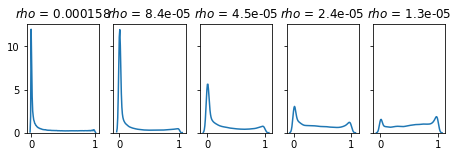

In [241]:
n=5
k = np.zeros([n])
etas = np.linspace(0,1,10)
rhos = np.logspace(-3.8,-4.9,n)
etasq = 1
fig,ax = plt.subplots(1,n,figsize=(n*1.5,2),sharey=True)
for j, rhosq in enumerate(rhos):
    Kij = etasq*(np.exp(-rhosq*Dmatsq))#+np.diag([sigmay]*Num_farms))
    sns.kdeplot(data=np.ravel(Kij),ax=ax[j])
    ax[j].set_title(r'$rho$ = {}'.format(round(rhosq,6)))


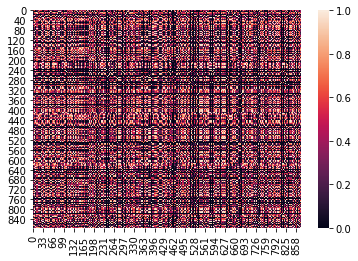

In [223]:
sns.heatmap(Kij)

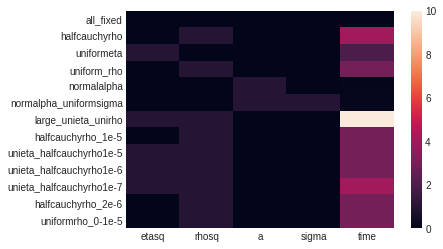

In [179]:
computetime = {'all_fixed':[0,0,0,0,.05],'halfcauchyrho':[0,1,0,0,4],'uniformeta':[1,0,0,0,2],
               'uniform_rho':[0,1,0,0,3],'normalalpha':[0,0,1,0,.1],
               'normalpha_uniformsigma':[0,0,1,1,.15],'large_unieta_unirho':[1,1,0,0,10.],
              'halfcauchyrho_1e-5':[0,1,0,0,3.],'unieta_halfcauchyrho1e-5':[1,1,0,0,3],
              'unieta_halfcauchyrho1e-6':[1,1,0,0,3],'unieta_halfcauchyrho1e-7':[1,1,0,0,4],
              'halfcauchyrho_2e-6':[0,1,0,0,3.],'uniformrho_0-1e-5':[0,1,0,0,3.],
              'covsigma0.5' : [1,1,1,1,2]}
                    
                             
comptime = pd.DataFrame.from_dict(computetime, orient='index',
   columns=['etasq','rhosq','a','sigma','time'])

sns.heatmap(comptime);

In [207]:
X = df_unique.Latitude.values[:,None]
Xu = X[::]
# ===== reparam ====

with pm.Model() as GP_reparam:
    
    R""" 
    
    Trying to model two levels of a hierarchy, similar to a bayesian hierarchical model, 
    except, using a Gaussian Process to shrink the lower level estimates to the mean of the 
    higher level group. That way I do not have to define discrete groups that each farm belong to, 
    but can share information from farm to farm based on how close it is to other farms.
    This measure of similarity is given by the kernel function which defines a covariance matrix
    for the Gaussian Process. The trick is inserting my linear submodel.
    
    """
    
    # ======== prior intercept =============
    a = pm.Normal('a', 0, .5, shape=Num_farms) # intercept to be trained unique to each farm
    b = pm.Normal('b', 0, .5, shape=Num_farms) # slope to be trained unique to each farm
    # ========== Linear Model =============== 
    u = a[zero_farm_idx]  + b[zero_farm_idx]*df.zprsum3 
    #============ Likelihood ==============
    sigma = pm.Uniform('sigma', 0,2)
    y = pm.Normal('NDVI', mu=u, sd=sigma, observed=df.zNDVIsum3)
    

    # ========== gaussian process ===========
    #kernel hyperparameter lengthscale
    rho = pm.HalfCauchy('rho', .5)
    rho =.1
    #kernel
    cov = pm.gp.cov.ExpQuad(1,ls=rho)
    gp = pm.gp.MarginalSparse(cov_func=cov)
    # initialize 20 inducing points with K-means
    # gp.util
    Xu = pm.gp.util.kmeans_inducing_points(20, X)
    sigma_gp = pm.Normal('sigma_gp',0,.5)
    # slope for the individual farms, need y to be output from y above
    w = gp.marginal_likelihood('w', X=X,Xu=Xu,y=b,noise=sigma_gp,is_observed=False)
    
 

    #trace = pm.sample(1000,tune=100,chains=1)
    #mp = pm.find_MAP()

In [208]:
#pm.traceplot(trace, varnames=['w','b']);

''

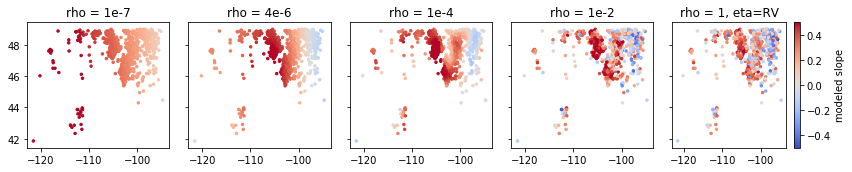

In [136]:
v=.5
fig, ax = plt.subplots(1,5,sharey=True,figsize=(12,2.5))
ax[0].set_title('rho = 1e-7')
ax[0].scatter(df_unique.Longitude,df_unique.Latitude,c=trace1['w'].mean(axis=0),
            cmap='coolwarm',vmax=v,vmin=-v,s=6)
ax[1].set_title('rho = 4e-6')
ax[1].scatter(df_unique.Longitude,df_unique.Latitude,c=trace['w'].mean(axis=0),
            cmap='coolwarm',vmax=v,vmin=-v,s=6)
ax[2].set_title('rho = 1e-4')
ax[2].scatter(df_unique.Longitude,df_unique.Latitude,c=trace2['w'].mean(axis=0),
            cmap='coolwarm',vmax=v,vmin=-v,s=6)
ax[3].set_title('rho = 1e-2')
im = ax[3].scatter(df_unique.Longitude,df_unique.Latitude,c=trace3['w'].mean(axis=0),
            cmap='coolwarm',vmax=v,vmin=-v,s=6)

ax[4].set_title('rho = 1, eta=RV')
ax[4].scatter(df_unique.Longitude,df_unique.Latitude,c=trace4['w'].mean(axis=0),
            cmap='coolwarm',vmax=v,vmin=-v,s=6)

fig.colorbar(im,ax=ax[4],label='modeled slope')
fig.tight_layout();

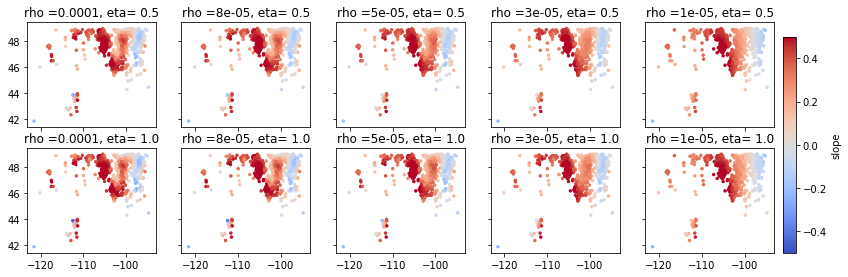

In [267]:
v=.5
fig, ax = plt.subplots(2,5,sharey=True,sharex=True,figsize=(12,4))
rhos = np.array([1e-4,8e-5,5e-5,3e-5,1e-5])
etas = np.array([.5,1])
 #empty trace dict to store traces in
# ==== Model I want to reparm =====
c = 0
for j, e in enumerate(etas):
    for i,r in enumerate(rhos):
        ax[j,i].set_title('rho ={}, eta= {}'.format((round(r,6)),e))
        im = ax[j,i].scatter(df_unique.Longitude,df_unique.Latitude,c=t['trace{}'.format(c+1)]['w'].mean(axis=0),
            cmap='coolwarm',vmax=v,vmin=-v,s=6)
        c += 1

plt.subplots_adjust(bottom=0.1, right=0.99, top=0.9)
cax = plt.axes([1, 0.1, 0.015, 0.75]) #right,bottom,width,top 
plt.colorbar(im,cax=cax,label='slope');
#fig.tight_layout();

In [255]:
c=1
t['trace{}'.format(c+1)].mean()

AttributeError: 'MultiTrace' object has no attribute 'mean'

In [209]:
# add the GP conditional to the model, given the new X values
X_new = np.linspace(40,50,100)[:,None]#np.linspace(40,50,100)[:,None]
#with GP_reparam:
#    f_pred = gp.conditional("f_pred", X_new)
    
#with GP_reparam:
#    fs =  gp.conditional('fss', X_new)
    # To use the MAP values, you can just replace the trace with a length-1 list with `mp`
#with GP_reparam:
#    pred_samples = pm.sample_posterior_predictive([trace], vars=[fs], samples=2000)